In [13]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx

from plnn.io import load_model_from_directory, load_model_training_metadata
from plnn.dataset import get_dataloaders
from plnn.pl import plot_phi

from plnn.models.algebraic_pl import AlgebraicPL

In [14]:
STUDY = "tr_study1" 
RIDX = 2
TIMESTAMP = "20240309_135700" 

OUTDIR = "out"
DATDIR = "../data/transition_rate_studies"
MODELDIR = "../data/transition_rate_study_results/transition_rate_study_model_training_kl1_1"

SEED = None

In [15]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__ # type: ignore
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

SCRIPT = not is_notebook()

if SCRIPT:
    parser = argparse.ArgumentParser()
    parser.add_argument("-s", "--study", type=str, required=True)
    parser.add_argument("-r", "--ridx", type=int, required=True)
    parser.add_argument("-t", "--timestamp", type=str, required=True)
    parser.add_argument("-o", "--outdir", type=str, required=True)
    parser.add_argument("-d", "--datdir", type=str, 
        default="data/transition_rate_studies")
    parser.add_argument("-m", "--modeldir", type=str, 
        default="data/transition_rate_study_results/transition_rate_study_model_training_kl1_1")
    parser.add_argument("--seed", type=int, default=None)
    args = parser.parse_args()

In [16]:
if SCRIPT:
    STUDY = args.study
    RIDX = args.ridx
    TIMESTAMP = args.timestamp
    OUTDIR = args.outdir
    DATDIR = args.datdir
    MODELDIR = args.modeldir
    SEED = args.seed

rng = np.random.default_rng(SEED)
key = jrandom.PRNGKey(rng.integers(2**32))

In [17]:
modeldir = f"{MODELDIR}/{STUDY}/model_{STUDY}_r{RIDX}_{TIMESTAMP}"

In [18]:
datdir_train = f"{DATDIR}/{STUDY}/{STUDY}_training/r{RIDX}"
datdir_valid = f"{DATDIR}/{STUDY}/{STUDY}_validation/r{RIDX}"
datdir_test = f"{DATDIR}/{STUDY}/{STUDY}_testing/r{RIDX}"

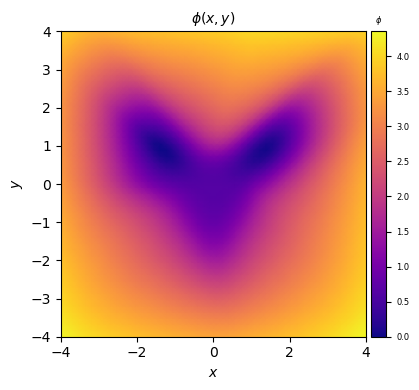

In [19]:
model, hyperparams, idx, modelname, model_fpath = load_model_from_directory(
    modeldir,
    subdir="states",
    idx=-1,
)

_ = model.plot_phi(show=True)

In [20]:
nsims_train = np.genfromtxt(f"{datdir_train}/nsims.txt", dtype=int)
nsims_valid = np.genfromtxt(f"{datdir_valid}/nsims.txt", dtype=int)
nsims_test = np.genfromtxt(f"{datdir_test}/nsims.txt", dtype=int)

_, _, test_loader, _, _, test_dset = get_dataloaders(
    datdir_train, datdir_valid, nsims_train, nsims_valid,
    return_datasets=True,
    include_test_data=True,
    datdir_test=datdir_test, nsims_test=nsims_test,
)

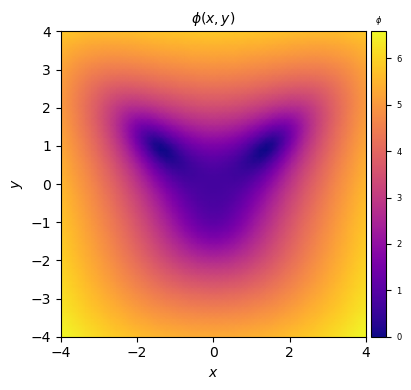

In [21]:
key, subkey = jrandom.split(key)
modelstar, _ = AlgebraicPL.make_model(
    key=subkey,
    dtype=jnp.float64,
    algebraic_phi_id="phi1",
    tilt_weights=[[-1, 0],[0, 1]],
    tilt_bias=[0, 0],
    sigma_init=0.1,
    signal_type="sigmoid",
    nsigparams=4,
)

_ = modelstar.plot_phi(show=True)

In [22]:
ksamp = -1

if ksamp < 0:
    ksamp = len(test_dset[0][1])
    
ncells_plot = ksamp * len(test_dset)

error_f = np.zeros(len(test_dset))
error_f_normed = np.zeros(len(test_dset))

plot_points = np.zeros([ncells_plot, 2])
plot_errors_f = np.zeros(ncells_plot)
plot_errors_f_normed = np.zeros(ncells_plot)

for i, data in enumerate(test_dset):
    inputs, x1 = data
    t0, x0, t1, sigparams = inputs
    n = len(x0)

    f = eqx.filter_jit(model.f)(t0, x0, sigparams)
    fstar = eqx.filter_jit(modelstar.f)(t0, x0, sigparams)

    assert f.shape == (n,2)
    assert fstar.shape == (n,2)

    f_normed = f / jnp.linalg.norm(f, axis=1)[:,None]
    fstar_normed = fstar / jnp.linalg.norm(fstar, axis=1)[:,None]
    assert f_normed.shape == (n,2)
    assert fstar_normed.shape == (n,2)

    df = jnp.linalg.norm(f - fstar, axis=1)
    df_normed = jnp.linalg.norm(f_normed - fstar_normed, axis=1)
    assert df.shape == (n,)
    assert df_normed.shape == (n,)

    error_f[i] = df.mean()
    error_f_normed[i] = df_normed.mean()

    randints = rng.choice(n, ksamp, replace=False)
    
    plot_points[i*ksamp:(i+1)*ksamp, :] = x0[randints,:]
    plot_errors_f[i*ksamp:(i+1)*ksamp] = df[randints]
    plot_errors_f_normed[i*ksamp:(i+1)*ksamp] = df_normed[randints]

error_f_average = error_f.mean()
error_f_normed_average = error_f_normed.mean()

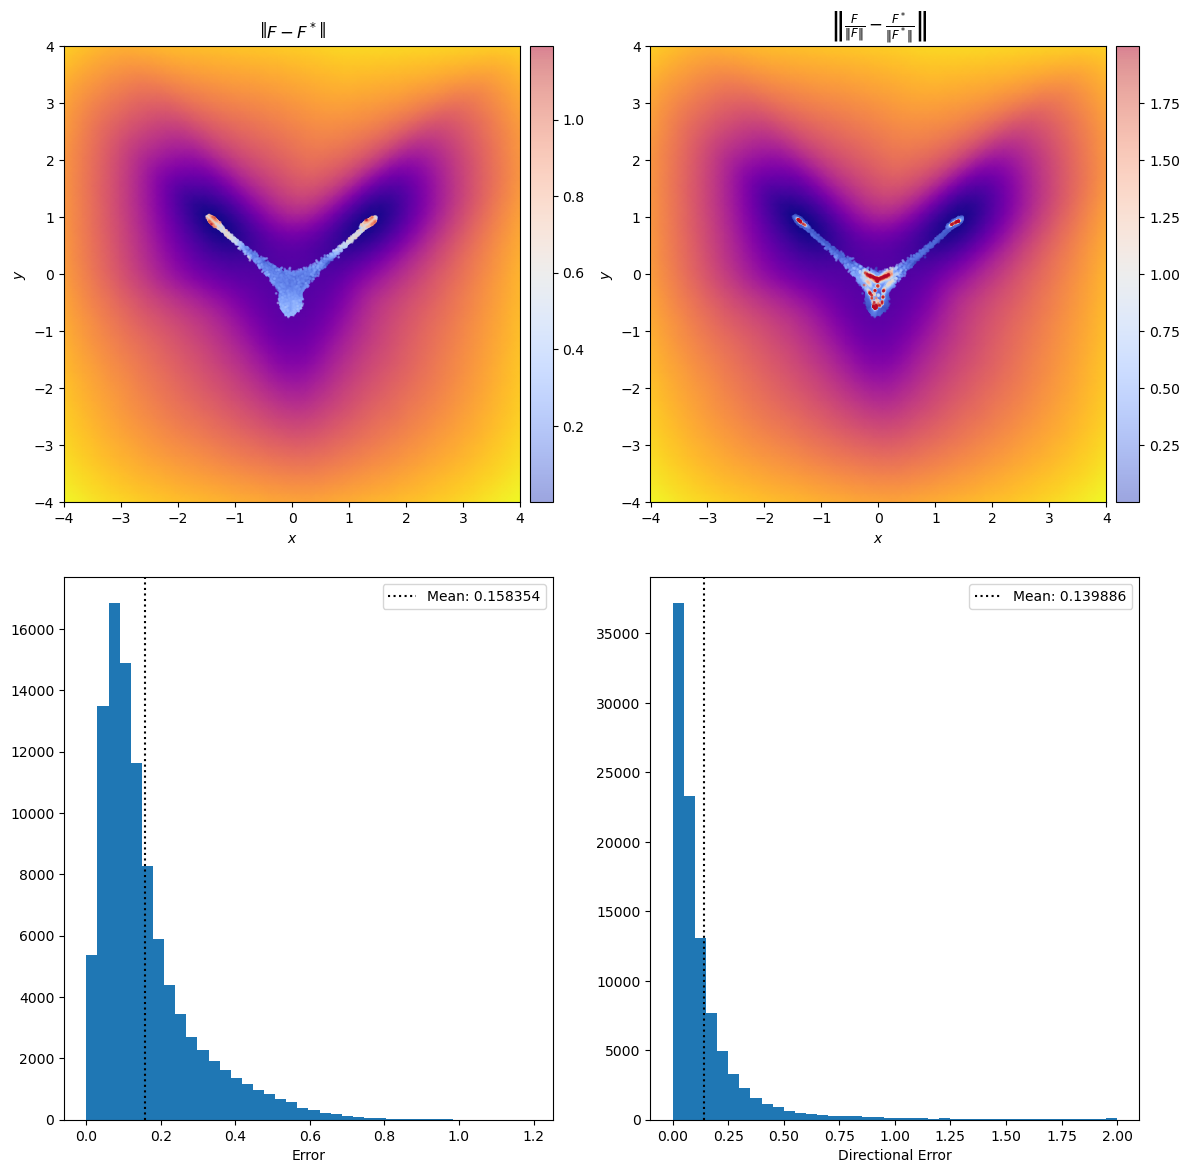

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12,12))

ax = axes[0][0]
plot_phi(
    model, 
    ax=ax,
    show=True,
    include_cbar=False
)

plot_under = np.inf

error = plot_errors_f
min_error = error.min()
max_error = error.max()

err_ordered_idxs = np.argsort(error)
ordered_error = error[err_ordered_idxs]
ordered_plot_points = plot_points[err_ordered_idxs,:]
screen = err_ordered_idxs < plot_under

sc = ax.scatter(
    ordered_plot_points[screen,0], ordered_plot_points[screen,1], s=1, 
    c=ordered_error[screen], 
    cmap='coolwarm',
    alpha=0.5,
    # vmin=min_error,
    # vmax=max_error,
)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = fig.colorbar(sc, cax=cax, orientation="vertical")

ax.set_title("$\left\| F - F^* \\right\|$")


ax = axes[1][0]
ax.hist(error, bins=40)
ax.set_xlabel("Error")
ax.axvline(error_f_average, 0, 1, color='k', linestyle=':', 
           label=f"Mean: {error_f_average:.6g}")
ax.legend()

##############################################################################
ax = axes[0][1]
plot_phi(
    model, 
    ax=ax,
    show=True,
    include_cbar=False
)

plot_under = np.inf

error = plot_errors_f_normed
min_error = error.min()
max_error = error.max()

err_ordered_idxs = np.argsort(error)
ordered_error = error[err_ordered_idxs]
ordered_plot_points = plot_points[err_ordered_idxs,:]
screen = err_ordered_idxs < plot_under

sc = ax.scatter(
    ordered_plot_points[screen,0], ordered_plot_points[screen,1], s=1, 
    c=ordered_error[screen], 
    cmap='coolwarm',
    alpha=0.5,
    # vmin=min_error,
    # vmax=max_error,
)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = fig.colorbar(sc, cax=cax, orientation="vertical")

ax.set_title("$\left\| \\frac{F}{ \| F \|} - \\frac{F^*}{\|F^*\|}\\right\|$")


ax = axes[1][1]
ax.hist(error, bins=40)
ax.set_xlabel("Directional Error")
ax.axvline(error_f_normed_average, 0, 1, color='k', linestyle=':', 
           label=f"Mean: {error_f_normed_average:.6g}")
ax.legend()


plt.tight_layout()
plt.savefig(f"{OUTDIR}/error_analysis_r{RIDX}_{STUDY}_{TIMESTAMP}")

In [24]:
t = 0.
sigparams = jnp.array([[2, 0, 1, 1], [2, 0, 1, 1]], dtype=jnp.float64)
y = jnp.array([1, 1], dtype=jnp.float64)


modelstar.eval_jacobian(t, y, sigparams)

Array([[ -4.,   8.],
       [  8., -20.]], dtype=float64)